In [13]:
%matplotlib inline
import numpy as np # import numpy library as np
import matplotlib.pyplot as plt # import pyplot library as plt
from mpl_toolkits.mplot3d import Axes3D # import Axes3D from `mpl_toolkits.mplot3d`
import itertools
from itertools import compress
plt.style.use('ggplot') # use "ggplot" style for graphs

In [14]:
# Get all possible moves and the particles with possible moves
def get_neighbors_3d(arr, R):
    
    # Array of 0s, where a 1 indicates a move possible
    boolarr = np.full(np.shape(arr), 0, dtype = int)

    # Array storing possible final positions per particle
    finalarr = np.full(np.shape(R)[0], 0, dtype = object)
    
    # Find indices of particles in array
    idx = R
    #indices = [tuple((ind[0], ind[1], ind[2])) for ind in idx]
    indices = np.array([np.array([x[0], x[1], x[2]]) for x in idx])
    
    # Find all possible moves to see if sites are occupied
    moves = list(itertools.product([-1, 0, 1], repeat=3))
    #moves = [tuple((move[0], move[1], move[2])) for move in moves]
    moves = np.array([np.array([x[0], x[1], x[2]]) for x in moves])
    
    # Loop over particle indices
    count = 0
    for ind in indices:
        temp_final = []

        # Loop over possible moves
        for move in moves:
            change = ind + move

            # If it's BC, continue
            if any(x > 30 for x in tuple(change)) or any(y < 1 for y in tuple(change)):
                continue
            # Check if a move goes onto a free space, if so note this and write down the move
            elif arr[tuple(change)] == 0:
                boolarr[tuple(ind)] = 1
                temp_final.append(change)
        
        if boolarr[tuple(ind)] == 1:
            finalarr[count] = np.asarray(temp_final)
        count += 1
    
    return boolarr, finalarr


In [15]:
# VARIABLES USED FOR DIFFUSION EQUATION
nx = 31 # length in x
ny = 31 # length in y
nz = 31 # length in z
nt = 17 # length in time
D = 1 # diffusion constant
dx = 2 / (nx - 1) # step size in x
dy = 2 / (ny - 1) # step size in y
dz = 2 / (nz - 1) # step size in z
#dt = dx**2 * dy**2 * dz**2 / (3 * D * (dx**2 + dy**2 + dz**2))
sigma = 1/6
dt = sigma * dx * dy * dz / D
#dt = 1

In [16]:
dim = 3 # system dimension (x,y,z)
nums = 1001 # number of simulation steps

np.random.seed() # initialize random number generator with a seed=0

u0 = np.zeros((nx, ny, nz))
u0[int(1 / dx):int(1.5 / dx), int(1 / dy):int(1.5 / dy), int(1 / dz):int(1.5 / dz)] = 1

x0,y0,z0 = u0.nonzero()

density = 1

nump = density*len(x0) # number of particles
print(nump)

if density != 1:
    xc = np.copy(x0)
    yc = np.copy(y0)
    zc = np.copy(z0)

    for i in range(1,density):
        x0 = np.append(x0, xc-1/density)
        y0 = np.append(y0, yc-1/density)
        z0 = np.append(z0, zc-1/density)
        

#R = np.zeros([nump,dim]) # array to store current positions and set initial condition 
R = np.column_stack((x0,y0,z0))
R0 = np.column_stack((x0,y0,z0))

Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps)
Rs[0] = R0
time = np.zeros([nums]) # an array to store time at all steps

a = np.zeros(6)

# Find processes

# Step forward in x
a[0] = 1
# Step backward in x
a[1] = 1
# Step forward in y
a[2] = 1
# Step backward in y
a[3] = 1
# Step forward in y
a[4] = 1
# Step backward in y
a[5] = 1
    
a_0 = np.sum(a)

343


# Official Gillespie loop
for i in range(1,nums):
    
    tr = np.copy(R)
    u = np.zeros((nx, ny, nz))
    u[R[:,0],R[:,1],R[:,2]] = 1
    
    # Only move particles if they are not surrounded by other particles
    neighs = get_neighbors_3d(u)
    xn,yn,zn = neighs.nonzero()
    ind = np.column_stack((xn,yn,zn))

    r_2 = np.random.uniform(0,1,len(R))

    mu_temp = mu(a, r_2)

    factors = np.array(list(map(mu_change, mu_temp)))
    
    R[ind] = R[ind] + factors[ind]

    time[i]=i*dt # store time in each step in an array time
    
    # Implement boundary conditions and have boundary reflect it backwards
    bounds = np.where(np.logical_or(R>30, R<1))[0]
    R[bounds] = tr[bounds] - factors[bounds]
    #dupl = [i for i, x in enumerate(lst) if x == item]
    
    Rs[i,:,:] = R

    i += 1

In [17]:
# Temporary assignment for easier running of code
R = np.copy(R0)

# Official Gillespie loop
for i in range(1,nums):
    u = np.zeros((nx, ny, nz))
    u[R[:,0],R[:,1],R[:,2]] = 1
    
    # Only move particles that have possible moves
    neighs, locs = get_neighbors_3d(u, R)
    xn,yn,zn = neighs.nonzero()
    ind = np.column_stack((xn,yn,zn))
    
    # Find the particles that can be moved
    eq = (R[:, None] == ind).all(-1).any(-1)
    eq = [i for i, val in enumerate(eq) if val]
    part_arr = R[eq]
    locs = locs[eq]
    
    choices = locs[0][np.random.choice(locs[0].shape[0], 1, replace=False)][0]
    choices = choices.astype('object')
    choices = np.full((len(locs), len(choices)), 0, dtype = object)
    choices[0] = locs[0][np.random.choice(locs[0].shape[0], 1, replace=False)][0]

    for j in range(1, len(locs)): 
        loop = True
        indices = np.arange(0, locs[j].shape[0])
        
        temp = np.random.choice(indices, 1, replace=False)
        indices = np.delete(indices, np.where(indices == temp))
        choice = locs[j][temp][0]
        
        while choice.tolist() in choices.tolist() and loop == True:
            if indices.size == 0:
                loop == False
                break
            temp = np.random.choice(indices, 1, replace=False)
            indices = np.delete(indices, np.where(indices == temp))
            choice = locs[j][temp][0]
            
        if loop == False:
            print("Mission failed.")
            break
            
        choices[j] = choice
    
    #if loop == True:
        #print("Locations distributed.")
    
    
    #print("Indice shape {}".format(np.shape(ind)))
    #print("R shape {}".format(np.shape(R)))
    #print("Choice shape {}".format(np.shape(choices)))
    #print("Particle array shape {}".format(np.shape(part_arr)))

    #newloc = part_arr + move
    newloc = np.copy(choices)
    
    # Check for duplicates
    dupl = (R[:, None] == newloc).all(-1).any(-1)
    dupl = [i for i, val in enumerate(dupl) if val]
    #print(len(dupl))
    
    testR = np.copy(R)
    for j in range(len(eq)):
        R[eq[j]] = newloc[j]
    #print(np.shape(np.unique(R, axis=0)))
    #print('Loop {:.1f} completed'.format(i))
    
    """fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
    ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
    ax.set_xlim(0,np.amax(R[:,0])) # set x-range
    ax.set_ylim(0,np.amax(R[:,1])) # set y-range
    ax.set_zlim(0,np.amax(R[:,2])) # set z-range
    ax.set_xlabel(r"x",fontsize=20) # set x-label
    ax.set_ylabel(r"y",fontsize=20) # set y-label
    ax.set_zlabel(r"z",fontsize=20) # set z-label
    ax.view_init(elev=12,azim=120) # set view point
    for n in range(nump): # repeat from n=0 to nump-1
        ax.scatter(R[n,0],R[n,1],R[n,2],alpha=0.5) # plot trajectiries of all particle
    plt.show() # draw plots"""

    Rs[i,:,:] = R
    time[i]=i*dt # store time in each step in an array time

    i += 1

D = 0.07052280466475601 (Simulation via MSD)


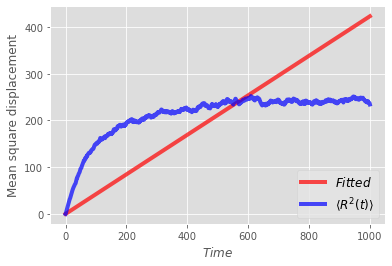

In [7]:
for i in range(nums):
    if np.size(Rs[i,:, :]) != np.size(np.unique(Rs[i,:, :], axis=1)):
        print("Particle overlap at ", i)

# mean square displacement vs time
msd1 = np.zeros([nums, nump])
for i in range(nums): # loop over time steps
    diff = Rs[i,:,:] - R0[:,:]
    pos2 = np.power(diff, 2)
    summ = np.sum(pos2, axis=1)
    msd1[i,:] = summ
    
msd = np.mean(msd1, axis=1)

dmsd = np.trapz(msd, dx=dt)/ (3*(nums*dt)**2) # integrate using trapezoidal rule

"""fit = np.polyfit(time, msd, 1)
print('Fitted D =',fit[0]/6,'in cm^2 min^-1')
d1 = fit[0]/6

predict = np.poly1d(fit)
theory = predict(time)"""

dmsdfit = 6*dmsd*time

#print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_xlabel(r"$Time$",fontsize=12)
ax.set_ylabel(r"Mean square displacement",fontsize=12)
#ax.plot(time,6*kBT/zeta*time,'k',lw=4, ls='dotted', label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time,dmsdfit,'r',lw=4, alpha=0.7, label=r'$Fitted$')
ax.plot(time, msd,'b',lw=4, alpha=0.7, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=12,loc=4)
plt.savefig('Figures/random discrete msd.pdf', bbox_inches='tight')
plt.show()

D = 0.3155264442284851 (Simulation via MSD)


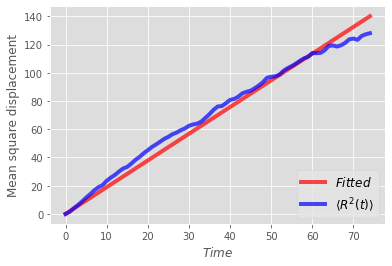

In [17]:
lint = 75

# mean square displacement vs time
msd1m = np.zeros([lint, nump])

for i in range(lint): # loop over time steps
    diff = Rs[i,:,:] - R0[:,:]
    pos2 = np.power(diff, 2)
    summ = np.sum(pos2, axis=1)
    msd1m[i,:] = summ
    
msdm = np.mean(msd1m, axis=1)

dmsdm = np.trapz(msdm, dx=dt)/ (3*(lint*dt)**2) # integrate using trapezoidal rule

"""fit = np.polyfit(time, msd, 1)
print('Fitted D =',fit[0]/6,'in cm^2 min^-1')
d1 = fit[0]/6

predict = np.poly1d(fit)
theory = predict(time)"""

dmsdfitm = 6*dmsdm*time[:lint]

#print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsdm,'(Simulation via MSD)')
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_xlabel(r"$Time$",fontsize=12)
ax.set_ylabel(r"Mean square displacement",fontsize=12)
#ax.plot(time,6*kBT/zeta*time,'k',lw=4, ls='dotted', label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time[:lint],dmsdfitm,'r',lw=4, alpha=0.7, label=r'$Fitted$')
ax.plot(time[:lint],msdm,'b',lw=4, alpha=0.7, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=12,loc=4)
plt.savefig('Figures/random discrete msd range.pdf', bbox_inches='tight')
plt.show()

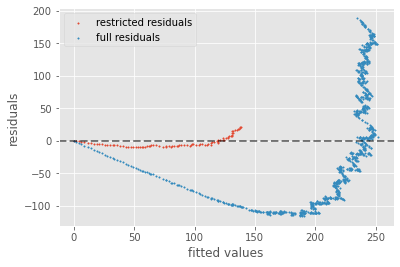

In [9]:
ratio1 = dmsdfitm - msd[:lint]

ratio2 = dmsdfit - msd

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(msd[:lint], ratio1, s=2, label='restricted residuals') # plot y/ya vs. t
ax.scatter(msd, ratio2, s=2, label='full residuals') # plot y/ya vs. t
ax.axhline(y=0, color='k', alpha=0.5, lw=2 ,linestyle='--')
ax.set_xlabel(r"fitted values", fontsize=12)
ax.set_ylabel(r"residuals", fontsize=12)
#ax.set_ylim(ymin=0.8, ymax= 1.1)
ax.legend() #display legends
plt.savefig('Figures/random discrete residuals.pdf', bbox_inches='tight')
plt.show() #display plots

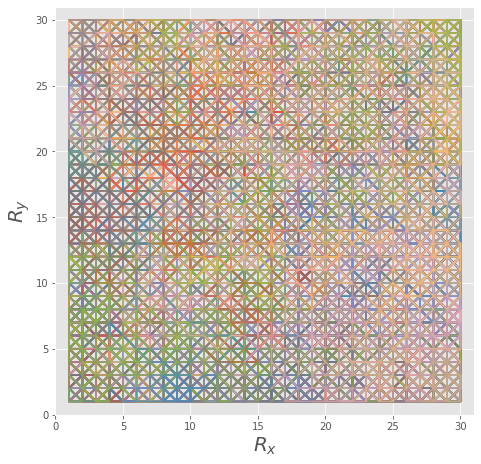

In [10]:
fig, ax = plt.subplots(figsize=(7.5,7.5)) # set fig with its size 7.5 x 7.5 inch
ax.set_xlabel(r"$R_x$", fontsize=20) # set x-label
ax.set_ylabel(r"$R_y$", fontsize=20) # set y-label
ax.set_xlim(0,nx) # set x-range
ax.set_ylim(0,ny) # set y-range
ax.plot(Rs[:,:,0],Rs[:,:,1],alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/random discrete 2D paths.pdf', bbox_inches='tight')
plt.show() # draw plots

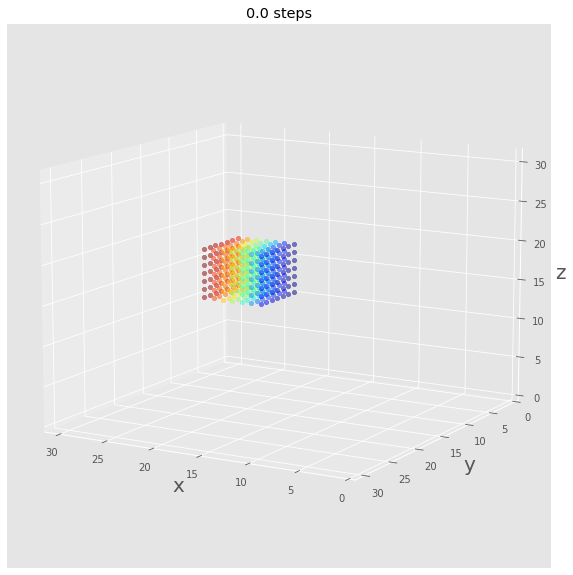

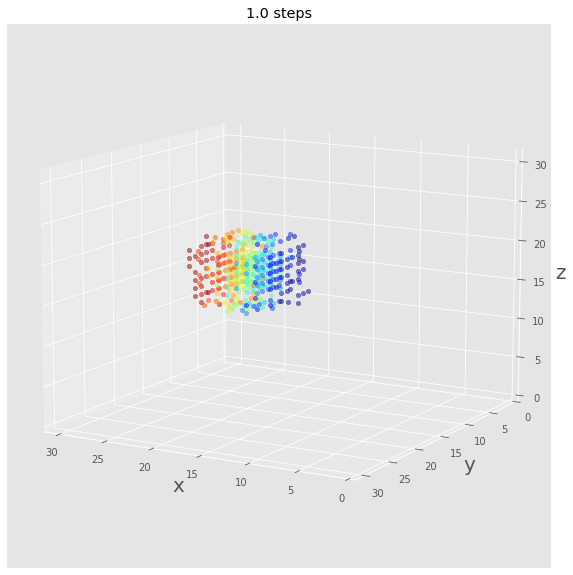

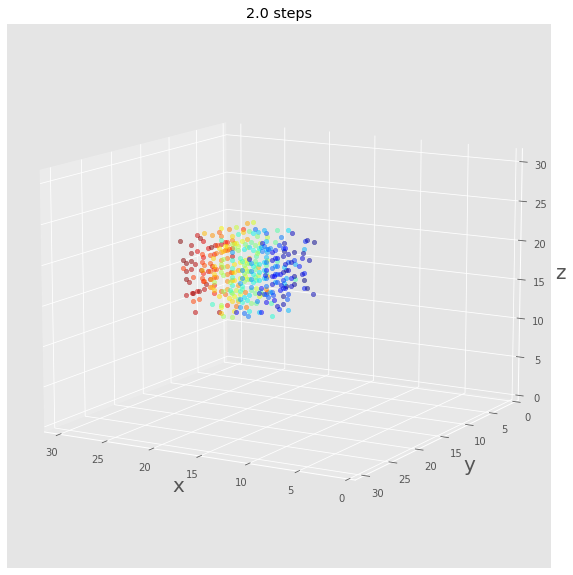

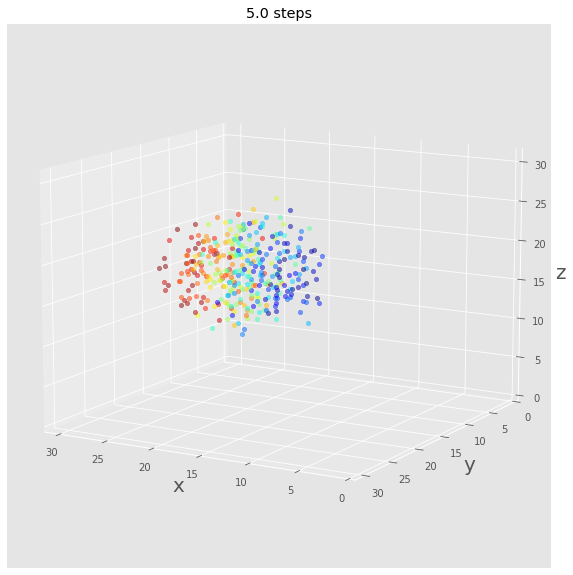

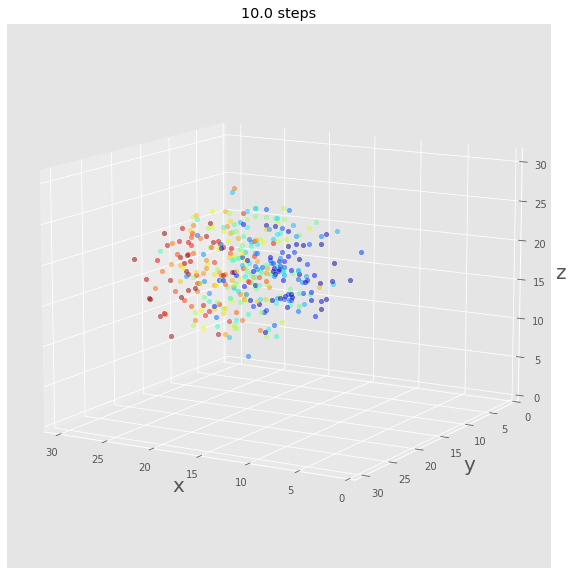

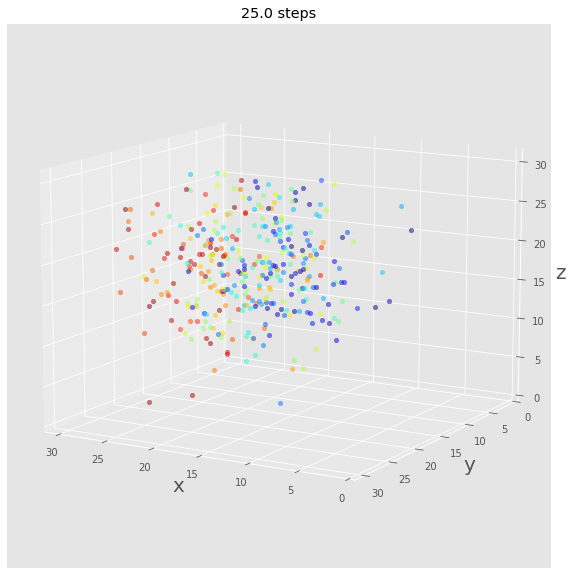

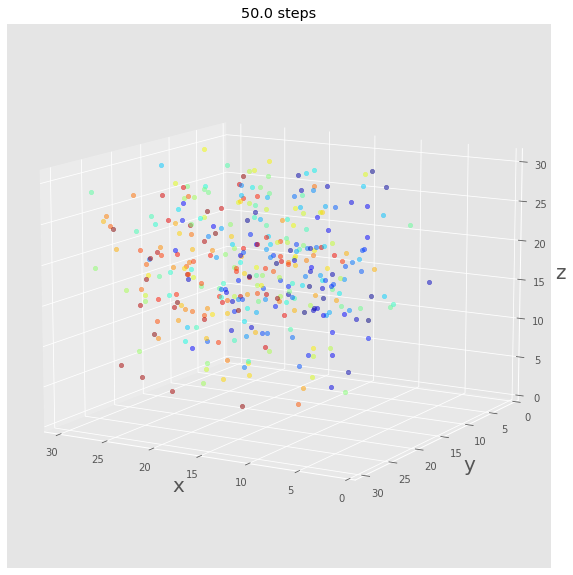

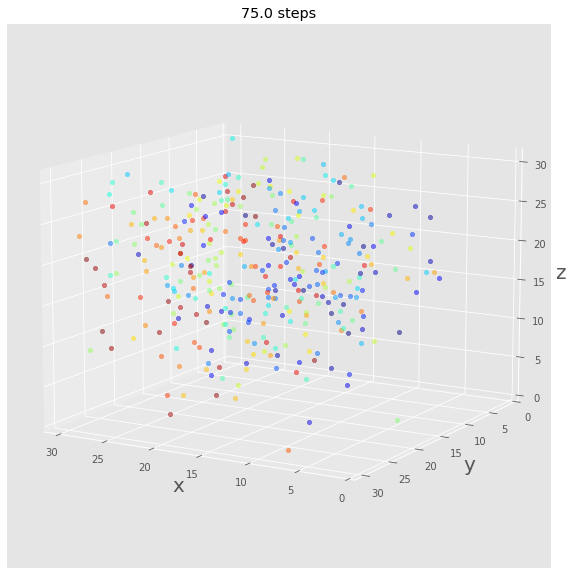

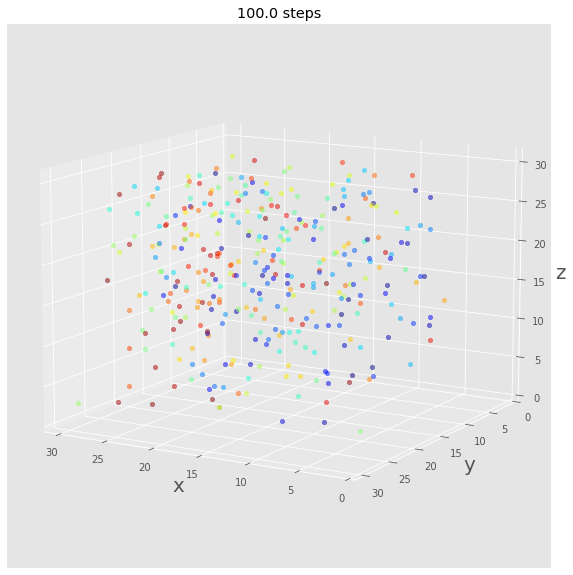

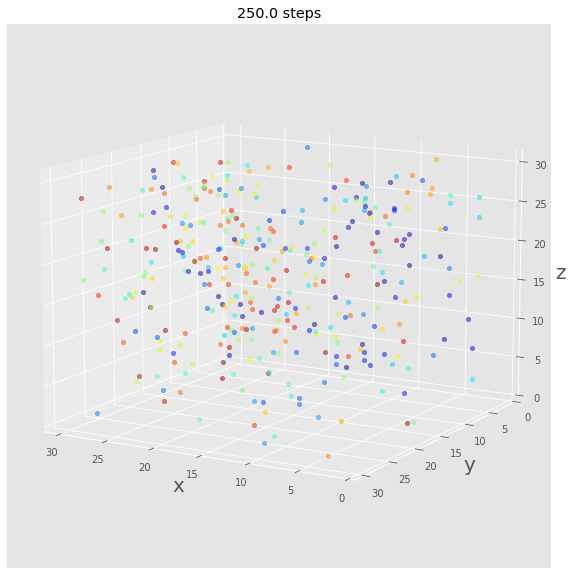

In [12]:
timesteps = [0, 1, 2, 5, 10, 25, 50, 75, 100, 250]

for ts in timesteps:
    jet= plt.get_cmap('jet')
    colors = iter(jet(np.linspace(0,1,nump)))
    fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
    ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
    time_ms = ts*dt*1000
    print('{:.1f} steps'.format(time_ms))
    #ax.set_title('{:.1f} steps'.format(ts))
    ax.set_xlim(0,nx) # set x-range
    ax.set_ylim(0,ny) # set y-range
    ax.set_zlim(0,nz) # set z-range
    ax.set_xlabel(r"x",fontsize=20) # set x-label
    ax.set_ylabel(r"y",fontsize=20) # set y-label
    ax.set_zlabel(r"z",fontsize=20) # set z-label
    ax.view_init(elev=12,azim=120) # set view point
    for n in range(nump): # repeat from n=0 to nump-1
        #if ts == 0:
        ax.scatter(Rs[ts,n,0],Rs[ts,n,1],Rs[ts,n,2],color=next(colors),alpha=0.5) # plot trajectiries of all particle
        #else:
            #ax.plot(Rs[:ts,n,0],Rs[:ts,n,1],Rs[:ts,n,2],color=next(colors),alpha=0.5) # plot trajectiries of all particle
    #ax.plot(Rs[:,0,0],Rs[:,0,1],Rs[:,0,2],alpha=0.5) 
    plt.savefig('Figures/random discrete 3D diffusion %s ms.pdf' % time_ms, bbox_inches='tight')
    plt.savefig('Figures/random discrete 3D diffusion %s ms.png' % time_ms, bbox_inches='tight')
    plt.show() # draw plots

0
11.876262430980212


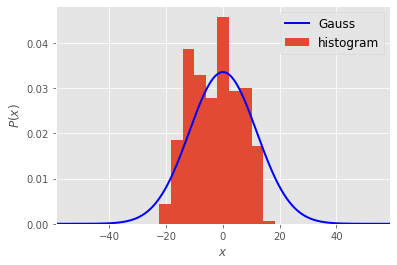

In [18]:
ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*kBT/zeta*time[nums-1]) # Standard deviation i.e. sqrt(2Dt)
std = np.sqrt(2*dmsd*time[nums-1]) # Standard deviation i.e. sqrt(2Dt)

nmin=int(ave-std*5)
nmax=int(ave+std*5)
nbin=int((nmax-nmin)/4)

fig = plt.figure()
ax = fig.add_subplot(111)

print(ave)
print(std)

ax.hist(Rs[nums-1,:,0]-Rs[0,:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'x-axis particle distribution')
ax.set_xlabel(r'$x$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x)$',fontsize=12) # set y-label
ax.legend([r'Gauss',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/random discrete x distr.pdf', bbox_inches='tight')
plt.show() # display plots

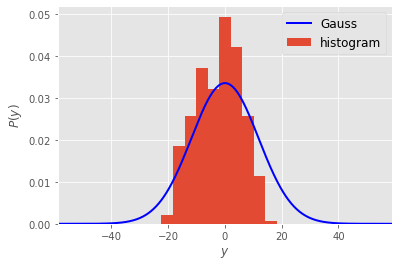

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(Rs[nums-1,:,1]-Rs[0,:,1],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment 
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$y$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(y)$',fontsize=12) # set y-label
ax.legend([r'Gauss',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/random discrete y distr.pdf', bbox_inches='tight')
plt.show() # display plots

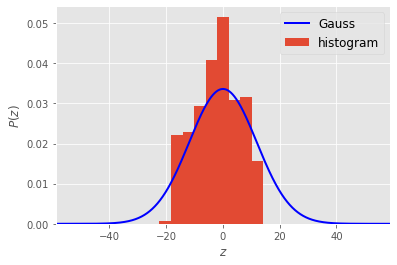

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(Rs[nums-1,:,2]-Rs[0,:,2],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment 
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'z-axis particle distribution')
ax.set_xlabel(r'$z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(z)$',fontsize=12) # set y-label
ax.legend([r'Gauss',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/random discrete z distr.pdf', bbox_inches='tight')
plt.show() # display plots

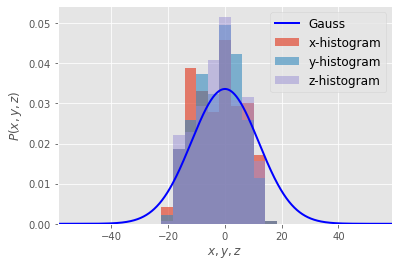

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(Rs[nums-1,:,0]-Rs[0,:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
ax.hist(Rs[nums-1,:,1]-Rs[0,:,1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
ax.hist(Rs[nums-1,:,2]-Rs[0,:,2],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment y = np.exp(-(x-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical plt.plot(x,y,lw=2,color='b') # plot y vs. x with blue line
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b',label=r'Gauss') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/random discrete xyz distr.pdf', bbox_inches='tight')
plt.show() # display plots